In [1]:
import findspark
import pyspark.sql
from tqdm.notebook import tqdm

from pyspark.sql import SparkSession
import pyspark
from delta import *

findspark.init()


DELTA_TABLE = "hdfs:///steam_reviews/steam_reviews_processed"
RECOMMEND_TABLE = "hdfs:///steam_reviews/steam_reviews_recommend"

# MVP

This is our MVP of how we want to server the data to the frontend. The first section is just getting and retrieving basic game data.

Further down is the implementation of the recommendation algorithm

In [2]:
from pyspark import RDD


class SteamReviews:
    """Class containing methods for interracting with steam reviews."""

    def __init__(
        self,
        name: str = "SteamReviews",
        delta_path: str = DELTA_TABLE,
    ) -> None:
        """Initialize the SteamReivews instance."""
        self.name = name
        self.delta_path = delta_path
        self.spark = self.get_spark()
        self.review = self.load_data()

    def get_spark(self) -> SparkSession:
        """Creates the spark session."""
        print("--- Creating spark session ---")
        builder = (
            pyspark.sql.SparkSession.builder.appName(self.name)
            .config(
                "spark.sql.extensions",
                "io.delta.sql.DeltaSparkSessionExtension",
            )
            .config(
                "spark.sql.catalog.spark_catalog",
                "org.apache.spark.sql.delta.catalog.DeltaCatalog",
            )
        )

        return configure_spark_with_delta_pip(builder).getOrCreate()

    def load_data(self) -> pyspark.sql.DataFrame:
        """Loads or writes the data to the delta table."""
        print("--- Loading delta table ---")
        review = self.spark.read.format("delta").load(DELTA_TABLE)
        print("--- Loaded delta table ---")
        return review

    def get_distinct(self, column: str = "game") -> list[str]:
        """Retrieves all unique games."""
        return [g["game"] for g in self.review.select(column).distinct().collect()]

    def get_distinct_sorted(self, column: str = "game", asc: bool = False) -> list[str]:
        """Returns the values sorted by occurence."""
        print(
            f"--- Getting unique values for {column} sorted {'asc' if asc else 'desc'} ---"
        )
        distinct_and_occurence = self.review.groupBy(column).count()
        distinct_sorted = sorted(
            distinct_and_occurence.collect(), key=lambda game: game[1], reverse=not asc
        )
        return [(g["game"], g["count"]) for g in distinct_sorted]

    def get_reviews(self, game: str) -> list[dict]:
        """Get reviews relating to a game."""
        return self.review.filter(self.review["game"] == game).collect()


steam = SteamReviews()

--- Creating spark session ---
:: loading settings :: url = jar:file:/usr/local/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
io.delta#delta-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ffe998ec-4498-48e9-8514-a3b3db287e3c;1.0
	confs: [default]
	found io.delta#delta-spark_2.12;3.0.0 in central
	found io.delta#delta-storage;3.0.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 114ms :: artifacts dl 6ms
	:: modules in use:
	io.delta#delta-spark_2.12;3.0.0 from central in [default]
	io.delta#delta-storage;3.0.0 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |   0 

--- Loading delta table ---


--- Loaded delta table ---


In [3]:
steam.review.show()

+------+--------------+----------------+--------+--------------------+--------+--------------+------------------+-----------------------+
| appid|          game|recommendationid|language|              review|voted_up|author_steamid|author_num_reviews|author_playtime_forever|
+------+--------------+----------------+--------+--------------------+--------+--------------+------------------+-----------------------+
|632360|Risk of Rain 2|        53819387| english|     Fantastic game.|    true|       1987149|                 1|                   7129|
|632360|Risk of Rain 2|        53818613| english|"I need to add my...|    true|       3188304|                 7|                   4004|
|632360|Risk of Rain 2|        53818199| english|Great game -  ver...|    true|       2860073|                 2|                   5981|
|632360|Risk of Rain 2|        53817944| english|Risk of ree 2 is ...|    true|       2428665|                 1|                   4690|
|632360|Risk of Rain 2|        538

In [4]:
steam.review.count()

4582004

In [5]:
steam.get_reviews("Terraria")

[Row(appid='105600', game='Terraria', recommendationid='77156985', language='english', review='Great game for anyone that enjoys having fun', voted_up=True, author_steamid=2768553, author_num_reviews=3, author_playtime_forever=2032),
 Row(appid='105600', game='Terraria', recommendationid='77156379', language='english', review='fun', voted_up=True, author_steamid=3999965, author_num_reviews=4, author_playtime_forever=2883),
 Row(appid='105600', game='Terraria', recommendationid='77155868', language='english', review='GOOD GAME', voted_up=True, author_steamid=3209421, author_num_reviews=1, author_playtime_forever=2462),
 Row(appid='105600', game='Terraria', recommendationid='77155689', language='english', review='Too grindy and repetitive.', voted_up=False, author_steamid=3884821, author_num_reviews=36, author_playtime_forever=883),
 Row(appid='105600', game='Terraria', recommendationid='77155643', language='english', review='SOOO GOOD', voted_up=True, author_steamid=3209422, author_num_

In [6]:
games = steam.get_distinct(column="game")
print(len(games))
games

184


['Elite Dangerous',
 'Town of Salem',
 'Fallout 4',
 'Age of Mythology: Extended Edition',
 'Rust',
 "Tom Clancy's Rainbow Six Siege",
 'American Truck Simulator',
 'Middle-earth: Shadow of War',
 'The Isle',
 'Total War: NAPOLEON Definitive Edition',
 'Hollow Knight',
 'Kingdom Come: Deliverance',
 'DARK SOULS III',
 "No Man's Sky",
 'Mount & Blade II: Bannerlord',
 'Subnautica',
 'DARK SOULS II: Scholar of the First Sin',
 "Sid Meier's Civilization IV: Beyond the Sword",
 'FaceRig',
 'XCOM 2',
 'Darkest Dungeon',
 'Human: Fall Flat',
 'Wallpaper Engine',
 'Left 4 Dead 2',
 'DayZ',
 'The Sims 3',
 'NieR: Automata',
 'Borderlands 2',
 'Northgard',
 'Planet Coaster',
 'Total War: MEDIEVAL II Definitive Edition',
 'The Binding of Isaac: Rebirth',
 'Men of War: Assault Squad 2',
 'SCUM',
 'Europa Universalis IV',
 'Satisfactory',
 'Mount & Blade: Warband',
 'Euro Truck Simulator 2',
 'Counter-Strike: Source',
 'Deep Rock Galactic',
 'Kenshi',
 'The Elder Scrolls V: Skyrim Special Edition'

In [7]:
games_sorted = steam.get_distinct_sorted(column="game")
print(len(games_sorted))
games_sorted

--- Getting unique values for game sorted desc ---
184


[("PLAYERUNKNOWN'S BATTLEGROUNDS", 236369),
 ('Terraria', 196533),
 ('Among Us', 114362),
 ('DayZ', 106063),
 ('PAYDAY 2', 105099),
 ('The Elder Scrolls V: Skyrim', 95260),
 ("No Man's Sky", 91263),
 ('Dead by Daylight', 89047),
 ('Fall Guys', 87314),
 ('Left 4 Dead 2', 85657),
 ('Fallout 4', 81659),
 ('Subnautica', 78448),
 ('Rust', 74885),
 ('Portal 2', 74506),
 ('Stardew Valley', 70906),
 ('The Forest', 68539),
 ('Arma 3', 64299),
 ('Monster Hunter: World', 57917),
 ('Risk of Rain 2', 52958),
 ('Euro Truck Simulator 2', 52308),
 ('DARK SOULS III', 51795),
 ('7 Days to Die', 51367),
 ('Wallpaper Engine', 47996),
 ('Space Engineers', 46762),
 ('The Binding of Isaac: Rebirth', 46656),
 ('Factorio', 46070),
 ('Mount & Blade: Warband', 44534),
 ('Kerbal Space Program', 44376),
 ('RimWorld', 43543),
 ('Geometry Dash', 42942),
 ('Destiny 2', 42918),
 ('MORDHAU', 42428),
 ('Starbound', 41100),
 ('Dying Light', 39785),
 ('Hollow Knight', 39671),
 ('The Elder Scrolls Online', 37678),
 ('Mount

# Stats

In [8]:
steam.review.describe().show()

+-------+-----------------+--------------------+--------------------+--------+--------------------+-----------------+------------------+-----------------------+
|summary|            appid|                game|    recommendationid|language|              review|   author_steamid|author_num_reviews|author_playtime_forever|
+-------+-----------------+--------------------+--------------------+--------+--------------------+-----------------+------------------+-----------------------+
|  count|          4582004|             4582004|             4582004| 4582004|             4582004|          4582004|           4582004|                4582004|
|   mean|413555.8558128714|                NULL|5.0245985811757475E7|    NULL|                 NaN|2530402.462749487|10.182314114086326|     15882.072130011235|
| stddev|292608.1766596526|                NULL|2.0258235265425526E7|    NULL|                 NaN|892560.3740151213|26.179193899220127|     37420.496633071976|
|    min|               10|       

In [9]:
steam.review.show()

+------+--------------+----------------+--------+--------------------+--------+--------------+------------------+-----------------------+
| appid|          game|recommendationid|language|              review|voted_up|author_steamid|author_num_reviews|author_playtime_forever|
+------+--------------+----------------+--------+--------------------+--------+--------------+------------------+-----------------------+
|632360|Risk of Rain 2|        53819387| english|     Fantastic game.|    true|       1987149|                 1|                   7129|
|632360|Risk of Rain 2|        53818613| english|"I need to add my...|    true|       3188304|                 7|                   4004|
|632360|Risk of Rain 2|        53818199| english|Great game -  ver...|    true|       2860073|                 2|                   5981|
|632360|Risk of Rain 2|        53817944| english|Risk of ree 2 is ...|    true|       2428665|                 1|                   4690|
|632360|Risk of Rain 2|        538

In [10]:
# Num reviews per author

# import pyspark.pandas.plot as plt # https://spark.apache.org/docs/latest/api/python/reference/pyspark.pandas/api/pyspark.pandas.DataFrame.plot.hist.html
num_reviews = (
    steam.review.groupBy("author_steamid")
    .count()
    .withColumnRenamed("count", "review_count")
    .groupBy("review_count")
    .count()
    .toPandas()
)
num_reviews

,review_count,count
0,26,21
1,29,15
2,19,174
3,22,70
4,7,10780
5,34,6
6,50,1
7,32,7
8,31,6
9,39,3


In [11]:
mean_playtime_user = (
    steam.review.select(["author_steamid", "author_playtime_forever"])
    .groupBy("author_steamid")
    .mean("author_playtime_forever")
    .withColumnRenamed("avg(author_playtime_forever)", "mean_playtime_range")
    .toPandas()
)
mean_playtime_user["mean_playtime_range"] = (
    mean_playtime_user["mean_playtime_range"]
    .apply(lambda x: int(round((x / 60) / 200) * 200))
    .apply(lambda x: 4000 if x > 4000 else x)
)
mean_playtime_user = (
    mean_playtime_user.groupby("mean_playtime_range")
    .count()
    .reset_index("mean_playtime_range")
    .rename(columns={"author_steamid": "user_count"})
)
mean_playtime_user

,mean_playtime_range,user_count
0,0,1503973
1,200,850077
2,400,293120
3,600,145361
4,800,83171
5,1000,54641
6,1200,38432
7,1400,26397
8,1600,18969
9,1800,14097


In [12]:
mean_playtime = (
    steam.review.select(["appid", "author_playtime_forever"])
    .groupBy("appid")
    .mean("author_playtime_forever")
    .withColumnRenamed("avg(author_playtime_forever)", "mean_playtime_range")
    .toPandas()
)
mean_playtime["mean_playtime_range"] = (
    mean_playtime["mean_playtime_range"]
    .apply(lambda x: int(round((x / 60), -2)))
    .apply(lambda x: 1000 if x > 1000 else x)
)
mean_playtime = (
    mean_playtime.groupby("mean_playtime_range")
    .count()
    .reset_index("mean_playtime_range")
    .rename(columns={"appid": "game_count"})
)
mean_playtime

,mean_playtime_range,game_count
0,0,23
1,100,63
2,200,36
3,300,27
4,400,16
5,500,7
6,600,5
7,700,3
8,800,1
9,1000,3


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Barchart

The barchart (with a logarithmic y axis) show that a lot of reviewrs only reviewed a game once.

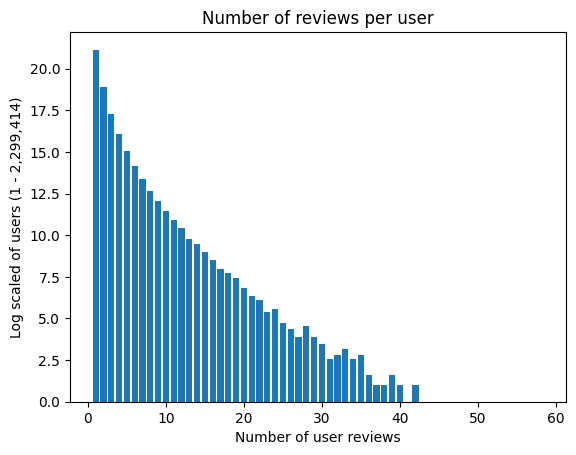

In [14]:
plt.bar(num_reviews["review_count"], np.log2(num_reviews["count"]))
plt.xlabel("Number of user reviews")
plt.ylabel("Log scaled of users (1 - 2,299,414)")
plt.title("Number of reviews per user")
plt.show()

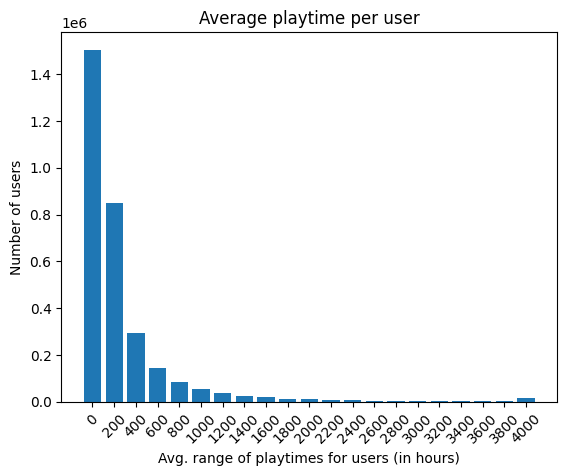

In [15]:
plt.bar(
    [str(x) for x in mean_playtime_user["mean_playtime_range"]],
    mean_playtime_user["user_count"],
)
plt.xlabel("Avg. range of playtimes for users (in hours)")
plt.xticks(rotation=45)
plt.ylabel("Number of users")
plt.title("Average playtime per user")
plt.show()

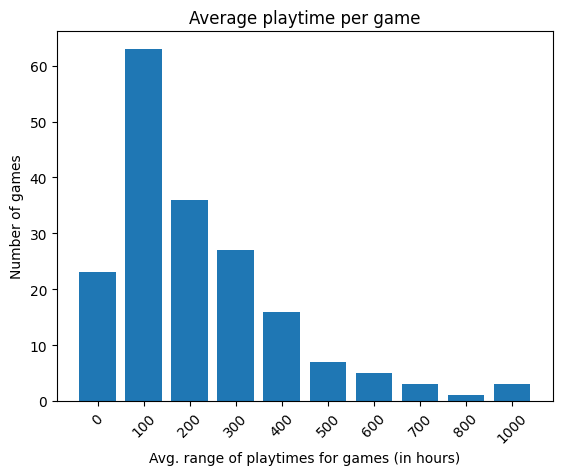

In [16]:
plt.bar(
    [str(x) for x in mean_playtime["mean_playtime_range"]], mean_playtime["game_count"]
)
plt.xlabel("Avg. range of playtimes for games (in hours)")
plt.ylabel("Number of games")
plt.xticks(rotation=45)
plt.title("Average playtime per game")
plt.show()

In [17]:
mean_playtime = None
mean_playtime_user = None

# Recommender System

To implement the recommender system we use Alternating Least Squares (ALS) to recommend users games based on other reviews

The idea to use ALS was from this recommender system article https://www.geeksforgeeks.org/recommender-system-using-pyspark-python/

For us to implement this we need to change the dataset a bit. This mostly entails extracting specific columns (appid, author_steamid, voted_up, author_playtime_forever) and converting them to integers types.


In [18]:
from pyspark.sql.functions import col, max, min
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.recommendation import ALS

In [19]:
steam.review.show()

+------+--------------+----------------+--------+--------------------+--------+--------------+------------------+-----------------------+
| appid|          game|recommendationid|language|              review|voted_up|author_steamid|author_num_reviews|author_playtime_forever|
+------+--------------+----------------+--------+--------------------+--------+--------------+------------------+-----------------------+
|632360|Risk of Rain 2|        53819387| english|     Fantastic game.|    true|       1987149|                 1|                   7129|
|632360|Risk of Rain 2|        53818613| english|"I need to add my...|    true|       3188304|                 7|                   4004|
|632360|Risk of Rain 2|        53818199| english|Great game -  ver...|    true|       2860073|                 2|                   5981|
|632360|Risk of Rain 2|        53817944| english|Risk of ree 2 is ...|    true|       2428665|                 1|                   4690|
|632360|Risk of Rain 2|        538

In [20]:
# Used chatGPT to figure out how to change the type of a row value
recommend_df = (
    steam.review.select(
        ["author_steamid", "appid", "voted_up", "author_playtime_forever"]
    )
    .withColumn("author_steamid", col("author_steamid").cast("integer"))
    .withColumn("appid", col("appid").cast("integer"))
    .withColumn("voted_up", col("voted_up").cast("integer"))
    .withColumn(
        "author_playtime_forever", col("author_playtime_forever").cast("integer")
    )
)

In [21]:
recommend_df.show()

+--------------+------+--------+-----------------------+
|author_steamid| appid|voted_up|author_playtime_forever|
+--------------+------+--------+-----------------------+
|       1987149|632360|       1|                   7129|
|       3188304|632360|       1|                   4004|
|       2860073|632360|       1|                   5981|
|       2428665|632360|       1|                   4690|
|       2870410|632360|       1|                   1727|
|       2428666|632360|       1|                  22770|
|       1766371|632360|       1|                   4534|
|       3629896|632360|       1|                   2323|
|       2428667|632360|       1|                   1342|
|       2747297|632360|       1|                    214|
|       3311538|632360|       1|                   2372|
|       1422022|632360|       1|                   7815|
|       3311539|632360|       1|                   6229|
|       2304672|632360|       1|                   2068|
|       3082118|632360|       1

# Deleting users with less than 3 reviews

In [22]:
recommend_df.count()

4582004

In [23]:
over_2_reviews = recommend_df.groupBy("author_steamid").count()
over_2_reviews = over_2_reviews.filter(over_2_reviews["count"] > 2)
recommend_df = over_2_reviews.join(recommend_df, on="author_steamid")

In [24]:
recommend_df.count()

1324170

# Create dataframe with min and max based on userid
Used chatGPT to find a way to group min and max playtime when grouped on author_steamid

In [25]:
recommend_df = recommend_df.join(
    recommend_df.select(["author_steamid", "author_playtime_forever"])
    .groupBy("author_steamid")
    .agg(
        min("author_playtime_forever").alias("min_playtime"),
        max("author_playtime_forever").alias("max_playtime"),
    ),
    on="author_steamid",
    how="left",
)

In [26]:
# Total number of distinct authors

recommend_df.select("author_steamid").distinct().count()

312869

In [ ]:
recommend_df = recommend_df.withColumn(
    "score",
    col("voted_up")
    * (
        (col("author_playtime_forever") - col("min_playtime"))
        / (1 + col("max_playtime") - col("min_playtime"))
    ),
)

In [28]:
recommend_df.show()

+--------------+-----+-------+--------+-----------------------+------------+------------+--------------------+
|author_steamid|count|  appid|voted_up|author_playtime_forever|min_playtime|max_playtime|               score|
+--------------+-----+-------+--------+-----------------------+------------+------------+--------------------+
|       1000003|    3|1030840|       1|                    729|         626|        2117|  0.0690348525469169|
|       1000003|    3|1030830|       1|                    626|         626|        2117|                 0.0|
|       1000003|    3|1174180|       1|                   2117|         626|        2117|  0.9993297587131368|
|       1000005|    5|    620|       1|                    496|         496|        2146|                 0.0|
|       1000005|    5|1250410|       1|                   1323|         496|        2146|   0.500908540278619|
|       1000005|    5|1030830|       1|                    725|         496|        2146|  0.1387038158691702|
|

In [29]:
train, test = recommend_df.randomSplit([0.6, 0.4])
train.show()

+--------------+-----+-------+--------+-----------------------+------------+------------+--------------------+
|author_steamid|count|  appid|voted_up|author_playtime_forever|min_playtime|max_playtime|               score|
+--------------+-----+-------+--------+-----------------------+------------+------------+--------------------+
|       1000003|    3|1030840|       1|                    729|         626|        2117|  0.0690348525469169|
|       1000005|    5|    620|       1|                    496|         496|        2146|                 0.0|
|       1000005|    5| 270880|       1|                   2146|         496|        2146|  0.9993943064809206|
|       1000005|    5| 945360|       1|                   1412|         496|        2146|  0.5548152634766808|
|       1000005|    5|1250410|       1|                   1323|         496|        2146|   0.500908540278619|
|       1000007|   12|    240|       1|                   2356|          81|       56021| 0.04066784648111403|
|

In [30]:
recommender = ALS(
    userCol="author_steamid",
    itemCol="appid",
    ratingCol="score",
    coldStartStrategy="drop",
)

In [31]:
model = recommender.fit(train)

In [32]:
predictions = model.transform(test)

In [33]:
predictions.show()

+--------------+-----+-------+--------+-----------------------+------------+------------+--------------------+------------+
|author_steamid|count|  appid|voted_up|author_playtime_forever|min_playtime|max_playtime|               score|  prediction|
+--------------+-----+-------+--------+-----------------------+------------+------------+--------------------+------------+
|       1000003|    3|1030830|       1|                    626|         626|        2117|                 0.0| 0.011296386|
|       1000003|    3|1174180|       1|                   2117|         626|        2117|  0.9993297587131368| 0.041897632|
|       1000005|    5|1030830|       1|                    725|         496|        2146|  0.1387038158691702|   0.0516165|
|       1000007|   12|  72850|       1|                  17753|          81|       56021| 0.31590425626999874|   0.2057594|
|       1000007|   12| 242760|       1|                    902|          81|       56021| 0.01467617668615148|   0.1156991|
|       

# Testing

In [34]:
rec = model.recommendForAllUsers(5)

In [35]:
rec.show()

+--------------+--------------------+
|author_steamid|     recommendations|
+--------------+--------------------+
|       1000003|[{1085660, 0.0484...|
|       1000005|[{48700, 0.716721...|
|       1000007|[{377160, 0.42912...|
|       1000019|[{72850, 0.705381...|
|       1000034|[{48700, 0.133204...|
|       1000042|[{4000, 0.6349225...|
|       1000043|[{900883, 0.0}, {...|
|       1000052|[{431960, 0.08160...|
|       1000055|[{48700, 0.250807...|
|       1000059|[{381210, 0.64010...|
|       1000062|[{1100600, 0.5409...|
|       1000066|[{900883, 0.0}, {...|
|       1000071|[{900883, 0.0}, {...|
|       1000072|[{377160, 0.70752...|
|       1000077|[{48700, 0.597722...|
|       1000084|[{629760, 0.75132...|
|       1000087|[{72850, 0.483141...|
|       1000088|[{377160, 0.11564...|
|       1000089|[{427520, 0.36066...|
|       1000101|[{582010, 0.02120...|
+--------------+--------------------+
only showing top 20 rows



In [36]:
rec.write.format("delta").mode("overwrite").save(RECOMMEND_TABLE)

In [37]:
def show_games_recommended(author_id: int):
    print(f"Reviewer {author_id}")
    recommended = rec.filter(rec["author_steamid"] == author_id).select(
        "recommendations"
    )
    games = steam.review.select(["appid", "game"]).distinct()
    author_played = steam.review.filter(
        steam.review["author_steamid"] == author_id
    ).select(["appid", "game", "author_playtime_forever"])
    games = games.join(
        steam.spark.createDataFrame(recommended.take(1)[0]["recommendations"]),
        on="appid",
    )
    print("Author Playlist")
    author_played.show()
    print("Recommendations")
    games.show()
    return games, author_played

In [38]:
import random

ids = random.sample(
    recommend_df.select("author_steamid").rdd.flatMap(lambda x: x).collect(), 8
)
for id in ids:
    show_games_recommended(id)

Reviewer 3879686


Author Playlist
+------+--------------------+-----------------------+
| appid|                game|author_playtime_forever|
+------+--------------------+-----------------------+
|268500|              XCOM 2|                  12431|
|220200|Kerbal Space Program|                   6319|
|281990|           Stellaris|                  10476|
|294100|            RimWorld|                  27955|
|646570|      Slay the Spire|                   1263|
|365360|     Battle Brothers|                   1274|
|427520|            Factorio|                  14015|
|233860|              Kenshi|                   5334|
|250900|The Binding of Is...|                     25|
|466560|           Northgard|                    572|
|105600|            Terraria|                   7885|
+------+--------------------+-----------------------+

Recommendations
+-------+--------------------+-------------------+
|  appid|                game|             rating|
+-------+--------------------+-------------------+
|110

Author Playlist
+-------+--------------------+-----------------------+
|  appid|                game|author_playtime_forever|
+-------+--------------------+-----------------------+
| 359550|Tom Clancy's Rain...|                  29761|
| 304390|           For Honor|                    393|
| 648800|                Raft|                    132|
|1097150|           Fall Guys|                    945|
| 945360|            Among Us|                    773|
| 960090|         Bloons TD 6|                   1871|
| 413150|      Stardew Valley|                   6877|
+-------+--------------------+-----------------------+

Recommendations
+------+--------------------+-------------------+
| appid|                game|             rating|
+------+--------------------+-------------------+
|383120|Empyrion: Galacti...|0.08829201012849808|
|413150|      Stardew Valley|0.10029294341802597|
|394360|   Hearts of Iron IV|0.08282103389501572|
|334230|       Town of Salem|0.08284159749746323|
|  4000|    

Author Playlist
+-------+--------------------+-----------------------+
|  appid|                game|author_playtime_forever|
+-------+--------------------+-----------------------+
|  72850|The Elder Scrolls...|                  27376|
| 578080|PLAYERUNKNOWN'S B...|                  37492|
|1085660|           Destiny 2|                   5449|
+-------+--------------------+-----------------------+

Recommendations
+------+--------------------+-------------------+
| appid|                game|             rating|
+------+--------------------+-------------------+
|284160|        BeamNG.drive| 0.3421589732170105|
|489830|The Elder Scrolls...|0.37057045102119446|
|427520|            Factorio|0.34132421016693115|
| 72850|The Elder Scrolls...| 0.5406894087791443|
|294100|            RimWorld|0.39062926173210144|
+------+--------------------+-------------------+

Reviewer 3966536


Author Playlist
+------+----------------+-----------------------+
| appid|            game|author_playtime_forever|
+------+----------------+-----------------------+
|218620|        PAYDAY 2|                  29208|
|431960|Wallpaper Engine|                    126|
|   550|   Left 4 Dead 2|                    600|
+------+----------------+-----------------------+

Recommendations
+------+--------------------+------------------+
| appid|                game|            rating|
+------+--------------------+------------------+
|218620|            PAYDAY 2|0.6030087471008301|
|359320|     Elite Dangerous|0.5345998406410217|
|250900|The Binding of Is...|0.5170933604240417|
|105600|            Terraria|0.4865202307701111|
| 48700|Mount & Blade: Wa...|0.5167049169540405|
+------+--------------------+------------------+

Reviewer 2133317


Author Playlist
+------+--------------------+-----------------------+
| appid|                game|author_playtime_forever|
+------+--------------------+-----------------------+
|261550|Mount & Blade II:...|                   1589|
|244850|     Space Engineers|                  36490|
| 48700|Mount & Blade: Wa...|                  59365|
|379430|Kingdom Come: Del...|                   3890|
+------+--------------------+-----------------------+

Recommendations
+------+--------------------+------------------+
| appid|                game|            rating|
+------+--------------------+------------------+
|359550|Tom Clancy's Rain...|0.7043834924697876|
| 48700|Mount & Blade: Wa...|0.8398071527481079|
|250900|The Binding of Is...|0.5649986267089844|
|359320|     Elite Dangerous|0.5759586691856384|
|233860|              Kenshi|0.5554593801498413|
+------+--------------------+------------------+

Reviewer 3237021


Author Playlist
+-------+--------------------+-----------------------+
|  appid|                game|author_playtime_forever|
+-------+--------------------+-----------------------+
| 582010|Monster Hunter: W...|                   1346|
|1097150|           Fall Guys|                   1995|
| 945360|            Among Us|                    985|
+-------+--------------------+-----------------------+

Recommendations
+------+--------------------+-------------------+
| appid|                game|             rating|
+------+--------------------+-------------------+
|582010|Monster Hunter: W...|0.28224462270736694|
|387990|      Scrap Mechanic|0.18975161015987396|
|287700|METAL GEAR SOLID ...|0.17418380081653595|
|573090|Stormworks: Build...|0.17439071834087372|
|594570|Total War: WARHAM...|0.17854081094264984|
+------+--------------------+-------------------+

Reviewer 1013150


Author Playlist
+------+--------------+-----------------------+
| appid|          game|author_playtime_forever|
+------+--------------+-----------------------+
|211820|     Starbound|                  12577|
|105600|      Terraria|                  22480|
|413150|Stardew Valley|                  13744|
+------+--------------+-----------------------+

Recommendations
+-------+--------------------+-------------------+
|  appid|                game|             rating|
+-------+--------------------+-------------------+
| 637090|          BATTLETECH|0.44687411189079285|
|1087280|Out of the Park B...| 0.5167132019996643|
| 787860|Farming Simulator 19| 0.4622493386268616|
|  39210|FINAL FANTASY XIV...| 0.5530367493629456|
| 105600|            Terraria| 0.8275244235992432|
+-------+--------------------+-------------------+

Reviewer 3484800


Author Playlist
+------+-----------------+-----------------------+
| appid|             game|author_playtime_forever|
+------+-----------------+-----------------------+
|311690|Enter the Gungeon|                   3309|
|431960| Wallpaper Engine|                  13190|
|960090|      Bloons TD 6|                     52|
+------+-----------------+-----------------------+

Recommendations
+-------+--------------------+-------------------+
|  appid|                game|             rating|
+-------+--------------------+-------------------+
| 872790|Football Manager ...| 0.5481502413749695|
| 431960|    Wallpaper Engine| 0.5895571112632751|
| 976310|    Mortal Kombat 11| 0.4287201166152954|
| 322170|       Geometry Dash| 0.4488556981086731|
|1151340|          Fallout 76|0.47088301181793213|
+-------+--------------------+-------------------+

